
# Option Pricing & Hedging Playbook (Math-First)

This notebook contains **five** self-contained sections you can run independently:
1. **Delta Hedging** (model-marked with Black–Scholes; hedge with underlying)
2. **Binomial Option Pricing** (CRR tree; European & American)
3. **Monte Carlo Option Pricing** (GBM; European)
4. **Brownian Motion in Finance** (path generation & distribution checks)
5. **Implied Volatility via Newton's Method** (invert BS from a given option price)

**Quick start**: Set the params in the first code cell of each section; run that section's cells top to bottom.


In [36]:

# === Shared Utilities (BS pricing, Greeks, Newton IV) ===
import numpy as np
import pandas as pd
from math import log, sqrt, exp
from scipy.stats import norm

def bs_price(S, K, T, r, sigma, opt_type="call"):
    """Black–Scholes price for European options."""
    if T <= 0:
        return max(0.0, S - K) if opt_type == "call" else max(0.0, K - S)
    if sigma <= 0:
        # intrinsic fallback
        return max(0.0, S - K) if opt_type == "call" else max(0.0, K - S)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if opt_type == "call":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def bs_delta(S, K, T, r, sigma, opt_type="call"):
    if T <= 0 or sigma <= 0:
        return 1.0 if (opt_type=="call" and S>K) else (0.0 if opt_type=="call" else -1.0 if S<K else 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1) if opt_type=="call" else (norm.cdf(d1)-1)

def bs_gamma(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S<=0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.pdf(d1) / (S*sigma*np.sqrt(T))

def bs_vega(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return S*norm.pdf(d1)*np.sqrt(T)

def implied_vol_newton(price, S, K, T, r, opt_type="call", sigma0=0.25, tol=1e-7, maxit=100):
    """Solve for sigma using Newton's method with simple safeguards. Returns np.nan if fails."""
    # Check arbitrage bounds
    intrinsic = max(0.0, S-K) if opt_type=="call" else max(0.0, K-S)
    upper = S if opt_type=="call" else K  # loose upper bound
    if not (intrinsic <= price <= upper):
        return np.nan
    sigma = max(1e-6, float(sigma0))
    for _ in range(maxit):
        v = bs_price(S, K, T, r, sigma, opt_type)
        diff = v - price
        if abs(diff) < tol:
            return max(sigma, 0.0)
        vg = bs_vega(S, K, T, r, sigma)
        if vg <= 1e-12:
            break
        sigma -= diff / vg
        # keep in reasonable bounds
        sigma = float(np.clip(sigma, 1e-6, 5.0))
    return np.nan


In [ ]:
# === Data Loading Helpers (project-aware) ===
from pathlib import Path
import sys

DATA_DIR = Path("data")              # when running from analysis/
INGEST_DIR = Path("../ingestion/yfinance")
sys.path.append(str(INGEST_DIR))

# Optional: your helper module (yfinance), if available
try:
    import yfinance_methods_v2 as ym
except Exception as e:
    ym = None
    print("yfinance_methods_v2 not found on path. Chain loader will be disabled.", e)

def load_ohlcv_from_cache():
    p = DATA_DIR / "ohlcv.csv"
    if not p.exists():
        raise FileNotFoundError("Expected analysis/data/ohlcv.csv. Run masterframes_ingestion.ipynb first.")
    df = pd.read_csv(p, parse_dates=["date"]).sort_values(["ticker","date"])
    return df

def get_spot_from_cache(ticker: str):
    df = load_ohlcv_from_cache()
    last = df[df["ticker"]==ticker].tail(1)
    if last.empty:
        raise ValueError(f"No OHLCV cached for {ticker}.")
    return float(last["close"].iloc[0])

def get_chain(ticker: str, expiry: str = None) -> pd.DataFrame:
    """Use your custom yfinance method if available; returns normalized chain (both calls & puts)."""
    if ym is None:
        raise ImportError("yfinance_methods_v2 is not importable; cannot fetch chain in this environment.")
    if expiry:
        ch = ym.get_options_chain(ticker, expiry)
    else:
        # fallback: find first available expiry via yfinance directly (only for the list)
        import yfinance as yf
        exps = yf.Ticker(ticker).options
        if not exps:
            raise RuntimeError(f"No expiries for {ticker}.")
        ch = ym.get_options_chain(ticker, exps[0])
    if ch is None or len(ch)==0:
        raise RuntimeError(f"Empty options chain for {ticker}.")
    # normalize 'mid' where possible
    if "bid" in ch.columns and "ask" in ch.columns:
        ch["mid"] = ch[["bid","ask"]].replace(0, np.nan).mean(axis=1)
    else:
        ch["mid"] = np.nan
    # ensure expected cols
    need = ["option_type","strike","last_price","mid","expiration_date"]
    for c in need:
        if c not in ch.columns: ch[c] = np.nan
    return ch

In [47]:
print(g[["date", "close", "rv20"]].tail(30))

                           date       close      rv20
11233 2025-07-10 04:00:00+00:00  212.410004  0.193135
11234 2025-07-11 04:00:00+00:00  211.160004  0.178613
11235 2025-07-14 04:00:00+00:00  208.619995  0.186513
11236 2025-07-15 04:00:00+00:00  209.110001  0.176466
11237 2025-07-16 04:00:00+00:00  210.160004  0.174779
11238 2025-07-17 04:00:00+00:00  210.020004  0.163685
11239 2025-07-18 04:00:00+00:00  211.179993  0.163774
11240 2025-07-21 04:00:00+00:00  212.479996  0.148387
11241 2025-07-22 04:00:00+00:00  214.399994  0.150003
11242 2025-07-23 04:00:00+00:00  214.149994  0.147082
11243 2025-07-24 04:00:00+00:00  213.759995  0.147777
11244 2025-07-25 04:00:00+00:00  213.880005  0.146520
11245 2025-07-28 04:00:00+00:00  214.050003  0.146428
11246 2025-07-29 04:00:00+00:00  211.270004  0.142328
11247 2025-07-30 04:00:00+00:00  209.050003  0.141704
11248 2025-07-31 04:00:00+00:00  207.570007  0.117809
11249 2025-08-01 04:00:00+00:00  202.380005  0.142459
11250 2025-08-04 04:00:00+00


## 1) Delta Hedging (Discrete, Model‑Marked)

We simulate daily **delta hedging** of a European call marked to **Black–Scholes theoretical prices**.  
Key ideas:
- Use underlying OHLCV from cache.
- Choose a maturity \(T\) and strike \(K\).
- Choose volatility \(\sigma_t\) as either a **constant** or a **realized vol stream** (e.g., 20‑day rolling).  
- Each day: compute BS price & delta; rebalance hedge in underlying; track P&L.

> This is a **didactic** hedging P&L, not a market-quoted backtest (we don't have real option quotes).

In [58]:
# --- Delta Hedging Simulation for Full Universe ---

r = 0.01
days_to_maturity = 30
use_realized_vol = True
const_sigma = 0.25
rebalance_every_n_days = 1

ohlcv = load_ohlcv_from_cache()
universe = sorted(ohlcv["ticker"].unique())
print(f"Universe size: {len(universe)} tickers")

all_sel = []

for ticker in universe:
    try:
        g = ohlcv[ohlcv["ticker"] == ticker].sort_values("date").copy()
        g["ret"] = g["close"].pct_change()
        g["rv20"] = g["ret"].rolling(20).std() * np.sqrt(252)
        g["date"] = pd.to_datetime(g["date"]).dt.tz_localize(None)
        sigma_series = g["rv20"].fillna(method="bfill") if use_realized_vol else pd.Series(const_sigma, index=g.index)

        # Window
        if g["close"].isna().all() or g["close"].size < 25:
            print(f"Skipped {ticker}: insufficient data")
            continue
        start_idx = g.index.get_loc(g.dropna().index[20])  # after we have RV
        end_idx = len(g) - 1
        S0 = g["close"].iloc[start_idx]
        K = S0  # ATM
        sel = g.iloc[start_idx : min(start_idx + days_to_maturity + 1, end_idx + 1)].copy()
        sel = sel.reset_index(drop=True)
        sel["date"] = pd.to_datetime(sel["date"]).dt.tz_localize(None)

        # T and sigma
        expiry_dt = sel["date"].iloc[-1]
        sel["T"] = (expiry_dt - sel["date"]).dt.days / 365.0
        sel["T"] = sel["T"].clip(lower=1/365)
        sel = sel.merge(
            g[["date", "rv20"]].rename(columns={"rv20": "sigma"}),
            on="date",
            how="left"
        )
        if sel["sigma"].isna().all():
            sel["sigma"] = const_sigma
        else:
            sel["sigma"] = sel["sigma"].fillna(method="bfill").fillna(method="ffill").fillna(const_sigma)

        sel["model_price"] = [
            bs_price(s, K, t, r, sig, "call")
            for s, t, sig in zip(sel["close"], sel["T"], sel["sigma"])
        ]
        sel["delta"] = [
            bs_delta(s, K, t, r, sig, "call")
            for s, t, sig in zip(sel["close"], sel["T"], sel["sigma"])
        ]

        # P&L simulation
        cash = 0.0
        shares = 0.0
        pnl = [0.0]
        for i in range(len(sel)):
            if i == 0 or (i % rebalance_every_n_days == 0):
                target_shares = sel["delta"].iloc[i]
                d_shares = target_shares - shares
                cash -= d_shares * sel["close"].iloc[i]
                shares = target_shares
            if i < len(sel) - 1:
                cash *= np.exp(r/252.0)
            portfolio = cash + shares*sel["close"].iloc[i] - sel["model_price"].iloc[i]
            pnl.append(portfolio)
        sel["hedge_pnl"] = pd.Series(pnl[:-1])  # align length

        sel["ticker"] = ticker
        sel["strike"] = K
        all_sel.append(sel)

    except Exception as e:
        print(f"Skipped {ticker}: {e}")

# Collect, re-order columns, and export
all_hedges = pd.concat(all_sel, ignore_index=True)
export_cols = ["ticker", "date", "close", "strike", "T", "sigma", "model_price", "delta", "hedge_pnl"]
outpath = DATA_DIR / f"delta_hedge_full_universe_{days_to_maturity}d.csv"
all_hedges[export_cols].to_csv(outpath, index=False)
print(f"Full-universe delta hedge results saved to: {outpath}")

all_hedges[export_cols].head()

Universe size: 20 tickers


C:\Users\sherv\AppData\Local\Temp\ipykernel_10668\2404966665.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sigma_series = g["rv20"].fillna(method="bfill") if use_realized_vol else pd.Series(const_sigma, index=g.index)
C:\Users\sherv\AppData\Local\Temp\ipykernel_10668\2404966665.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sel["sigma"] = sel["sigma"].fillna(method="bfill").fillna(method="ffill").fillna(const_sigma)
C:\Users\sherv\AppData\Local\Temp\ipykernel_10668\2404966665.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sigma_series = g["rv20"].fillna(method="bfill") if use_realized_vol else pd.Series(const_sigma, index=g.index)
C:\Users\sherv\AppData\Local\Temp\ipykernel_10668\2404966665.py:47: FutureW

Full-universe delta hedge results saved to: data\delta_hedge_full_universe_30d.csv


,ticker,date,close,strike,T,sigma,model_price,delta,hedge_pnl
0,AAPL,1981-02-10 05:00:00,0.121652,0.121652,0.117808,0.507267,0.008506,0.537374,0.000000
1,AAPL,1981-02-11 05:00:00,0.117746,0.121652,0.115068,0.514756,0.006574,0.462952,-0.008509
2,AAPL,1981-02-12 05:00:00,0.116629,0.121652,0.112329,0.504527,0.005814,0.437159,-0.008678
3,AAPL,1981-02-13 05:00:00,0.113839,0.121652,0.109589,0.507502,0.004624,0.380343,-0.008437
4,AAPL,1981-02-17 05:00:00,0.116629,0.121652,0.098630,0.455350,0.004615,0.414314,-0.008469


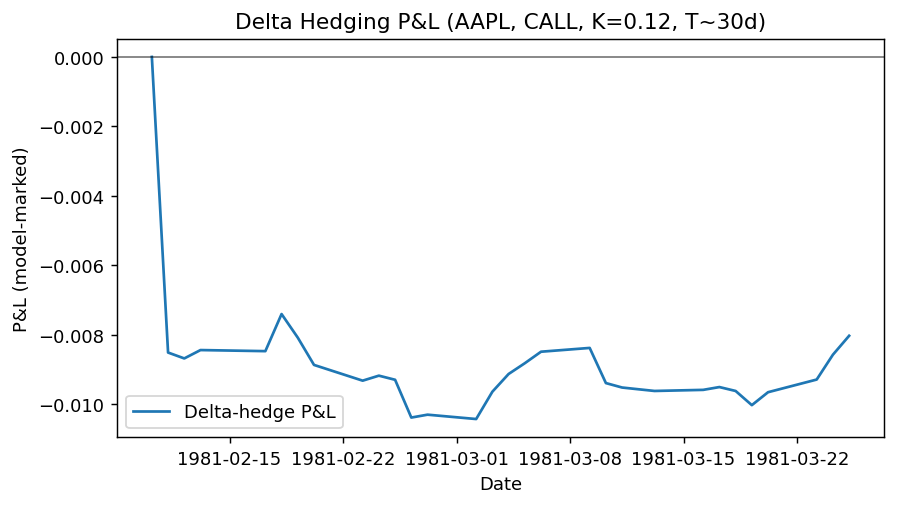

In [55]:
# Plot hedging P&L
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,4), dpi=130)
ax.plot(sel["date"], sel["hedge_pnl"], label="Delta-hedge P&L")
ax.axhline(0, lw=1, color="k", alpha=0.5)
ax.set_title(f"Delta Hedging P&L ({ticker}, {opt_type.upper()}, K={K:.2f}, T~{days_to_maturity}d)")
ax.set_xlabel("Date"); ax.set_ylabel("P&L (model-marked)")
ax.legend(); fig.tight_layout()
plt.show()


## 2) Binomial Option Pricing (CRR, American & European)

**Cox–Ross–Rubinstein (CRR)** tree with \(N\) steps:
- Up/down factors: \(u = e^{\sigma\sqrt{\Delta t}},\; d = 1/u\)
- Risk-neutral prob: \(p = \frac{e^{r\Delta t} - d}{u-d}\)
- Backward induction: European by expectation; American by early-exercise check.

This section prices a grid of strikes for both **European** and **American** options.


In [57]:
# --- Binomial Option Pricing for Full Universe ---

# Params
r = 0.01
T = 30/365.0
sigma = 0.25
N = 500  # binomial tree steps

# Load all tickers in your ohlcv cache
ohlcv = load_ohlcv_from_cache()
universe = sorted(ohlcv["ticker"].unique())
print(f"Universe size: {len(universe)} tickers")

# Price grid: will be scaled around each ticker's spot
Ks_grid = lambda S: np.linspace(0.8*S, 1.2*S, 21)

all_rows = []
for ticker in universe:
    try:
        S = get_spot_from_cache(ticker)
        Ks = Ks_grid(S)
        for K in Ks:
            all_rows.append({
                "ticker": ticker,
                "K": K,
                "T": T,
                "sigma": sigma,
                "Euro_Call": binomial_crr_price(S, K, T, r, sigma, N=N, american=False, opt_type="call"),
                "Amer_Call": binomial_crr_price(S, K, T, r, sigma, N=N, american=True,  opt_type="call"),
                "Euro_Put":  binomial_crr_price(S, K, T, r, sigma, N=N, american=False, opt_type="put"),
                "Amer_Put":  binomial_crr_price(S, K, T, r, sigma, N=N, american=True,  opt_type="put"),
            })
    except Exception as e:
        print(f"Skipped {ticker}: {e}")

# Create and export DataFrame
binom_all_df = pd.DataFrame(all_rows)
export_cols = ["ticker", "K", "T", "sigma", "Euro_Call", "Amer_Call", "Euro_Put", "Amer_Put"]
outpath = DATA_DIR / f"binomial_prices_full_universe.csv"
binom_all_df[export_cols].to_csv(outpath, index=False)
print(f"Full-universe binomial prices saved to: {outpath}")
binom_all_df.head()


Universe size: 20 tickers
Full-universe binomial prices saved to: data\binomial_prices_full_universe.csv


,ticker,K,T,sigma,Euro_Call,Amer_Call,Euro_Put,Amer_Put
0,AAPL,180.807996,0.082192,0.25,45.354019,45.354019,0.003471,0.003474
1,AAPL,185.328195,0.082192,0.25,40.845780,40.845780,0.011719,0.011727
2,AAPL,189.848395,0.082192,0.25,36.352615,36.352615,0.035041,0.035064
3,AAPL,194.368595,0.082192,0.25,31.893866,31.893866,0.092777,0.092846
4,AAPL,198.888795,0.082192,0.25,27.503101,27.503101,0.218499,0.218685


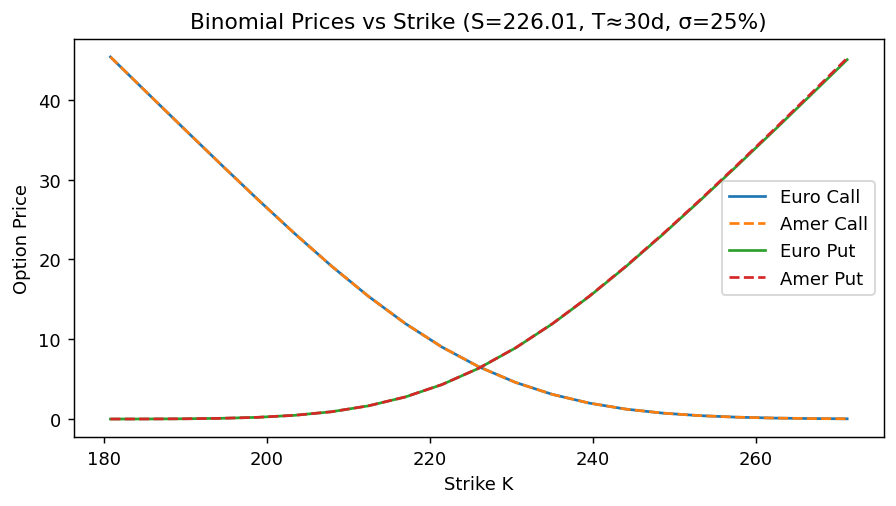

In [41]:

# Plot price vs strike
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,4), dpi=130)
ax.plot(binom_df["K"], binom_df["Euro_Call"], label="Euro Call")
ax.plot(binom_df["K"], binom_df["Amer_Call"], label="Amer Call", linestyle="--")
ax.plot(binom_df["K"], binom_df["Euro_Put"],  label="Euro Put")
ax.plot(binom_df["K"], binom_df["Amer_Put"],  label="Amer Put", linestyle="--")
ax.set_title(f"Binomial Prices vs Strike (S={S:.2f}, T≈30d, σ={sigma:.0%})")
ax.set_xlabel("Strike K"); ax.set_ylabel("Option Price")
ax.legend(); fig.tight_layout()
plt.show()



## 3) Monte Carlo Simulation (GBM, European)

Simulate geometric Brownian motion under risk-neutral dynamics:
\[ dS_t = r S_t dt + \sigma S_t dW_t \]
Discrete Euler scheme:
\[ S_{t+\Delta} = S_t \cdot \exp\big((r - \tfrac{1}{2}\sigma^2)\Delta + \sigma\sqrt{\Delta}\,Z\big) \]

We price European options by averaging discounted payoffs over simulated paths.


In [62]:
# --- Monte Carlo Simulation for Full Universe ---

r = 0.01
T = 30/365.0
sigma = 0.25

ohlcv = load_ohlcv_from_cache()
universe = sorted(ohlcv["ticker"].unique())
print(f"Universe size: {len(universe)} tickers")

all_rows = []
for ticker in universe:
    try:
        S = get_spot_from_cache(ticker)
        K = S  # ATM
        mc_call, mc_se_call = mc_price_euro(S, K, T, r, sigma, n_paths=30000, n_steps=60, opt_type="call")
        mc_put, mc_se_put = mc_price_euro(S, K, T, r, sigma, n_paths=30000, n_steps=60, opt_type="put")
        bs_call = bs_price(S, K, T, r, sigma, "call")
        bs_put = bs_price(S, K, T, r, sigma, "put")
        all_rows.extend([
            {"ticker": ticker, "K": K, "T": T, "sigma": sigma, "Instrument": "Call",
             "MC_Price": mc_call, "MC_StdErr": mc_se_call, "BS_ClosedForm": bs_call},
            {"ticker": ticker, "K": K, "T": T, "sigma": sigma, "Instrument": "Put",
             "MC_Price": mc_put, "MC_StdErr": mc_se_put, "BS_ClosedForm": bs_put},
        ])
    except Exception as e:
        print(f"Skipped {ticker}: {e}")

mc_univ_df = pd.DataFrame(all_rows)
outpath = DATA_DIR / "mc_option_prices_full_universe.csv"
mc_univ_df.to_csv(outpath, index=False)
print(f"Full-universe MC pricing results saved to: {outpath}")
mc_univ_df.head(20)


Universe size: 20 tickers
Full-universe MC pricing results saved to: data\mc_option_prices_full_universe.csv


,ticker,K,T,sigma,Instrument,MC_Price,MC_StdErr,BS_ClosedForm
0,AAPL,226.009995,0.082192,0.25,Call,6.487311,0.056783,6.551601
1,AAPL,226.009995,0.082192,0.25,Put,6.311842,0.051577,6.365916
2,AMZN,220.994995,0.082192,0.25,Call,6.343362,0.055523,6.406226
3,AMZN,220.994995,0.082192,0.25,Put,6.171787,0.050433,6.224661
4,BRK-B,487.089996,0.082192,0.25,Call,13.981259,0.122376,14.119816
5,BRK-B,487.089996,0.082192,0.25,Put,13.603094,0.111158,13.719633
6,DIA,447.059998,0.082192,0.25,Call,12.832252,0.112319,12.959422
7,DIA,447.059998,0.082192,0.25,Put,12.485165,0.102023,12.592127
8,GOOG,200.600006,0.082192,0.25,Call,5.757952,0.050399,5.815014
9,GOOG,200.600006,0.082192,0.25,Put,5.602211,0.045779,5.650205



## 4) Brownian Motion in Finance

We illustrate standard Brownian motion and GBM:
- Generate and plot multiple **Brownian paths**
- Show terminal distribution vs theoretical normal
- Map Brownian motion to **GBM** for price simulation


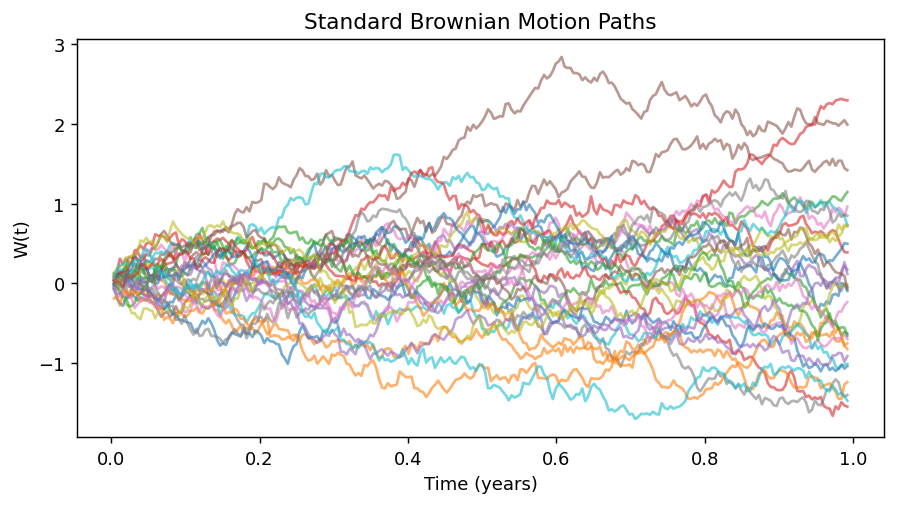

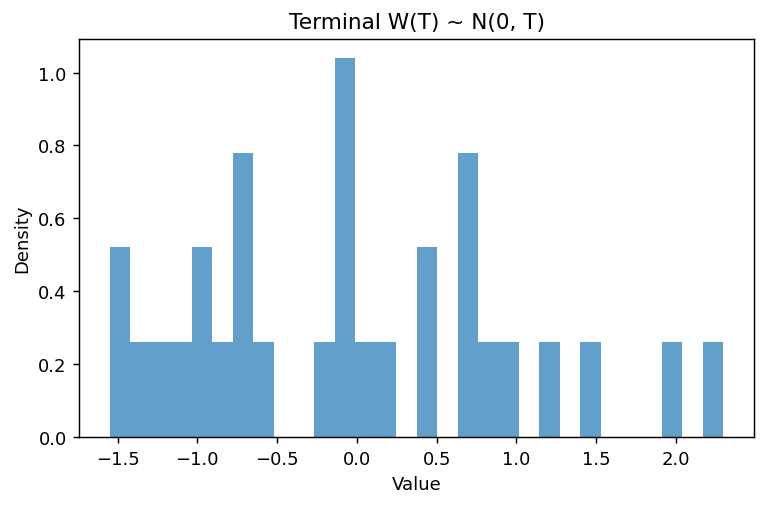

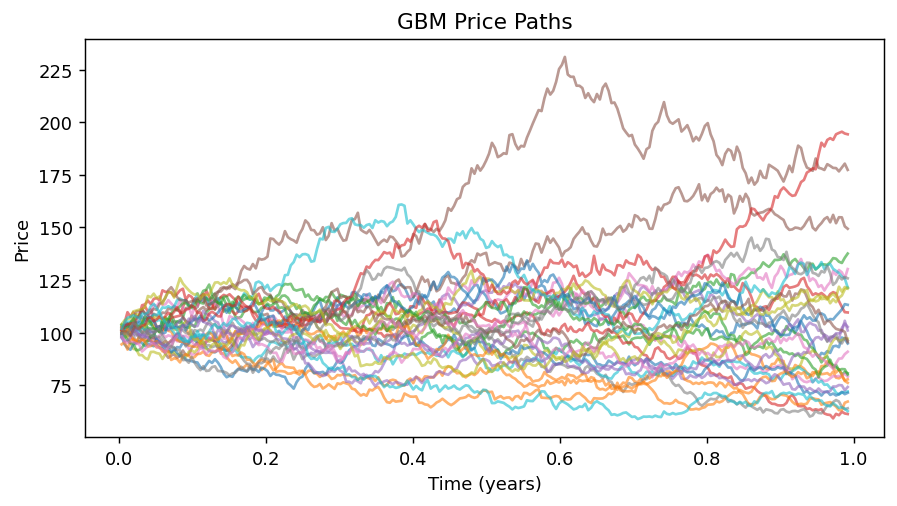

In [43]:

import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

# --- Brownian motion (standard) ---
n_paths = 30
n_steps = 250
dt = 1/252
dW = rng.standard_normal((n_paths, n_steps))*np.sqrt(dt)
W = np.cumsum(dW, axis=1)

fig, ax = plt.subplots(figsize=(7,4), dpi=130)
for i in range(n_paths):
    ax.plot(np.arange(1, n_steps+1)*dt, W[i], alpha=0.6)
ax.set_title("Standard Brownian Motion Paths")
ax.set_xlabel("Time (years)"); ax.set_ylabel("W(t)")
fig.tight_layout(); plt.show()

# --- Terminal distribution check ---
terminal = W[:,-1]
fig, ax = plt.subplots(figsize=(6,4), dpi=130)
ax.hist(terminal, bins=30, density=True, alpha=0.7)
ax.set_title("Terminal W(T) ~ N(0, T)"); ax.set_xlabel("Value"); ax.set_ylabel("Density")
fig.tight_layout(); plt.show()

# --- Map to GBM price paths ---
S0 = 100.0; r=0.02; sigma=0.3
t_grid = np.arange(1, n_steps+1)*dt
GBM = S0*np.exp((r-0.5*sigma**2)*t_grid + sigma*W)

fig, ax = plt.subplots(figsize=(7,4), dpi=130)
for i in range(n_paths):
    ax.plot(t_grid, GBM[i], alpha=0.6)
ax.set_title("GBM Price Paths")
ax.set_xlabel("Time (years)"); ax.set_ylabel("Price")
fig.tight_layout(); plt.show()



## 5) Implied Volatility via Newton's Method

Given an option price \(C(S,K,T,r)\), recover \(\sigma\) by solving \(C_{BS}(\sigma)=C\).  
We implement **Newton–Raphson** with vega as the derivative, and fall back to \(\text{NaN}\) when the input price is outside basic no-arbitrage bounds.


In [63]:

# --- Example with last_price from chain (if available), else BS synthetic ---
ticker = "AAPL"
opt_type = "call"
r = 0.01

# get spot and a chain (first available expiry)
S = get_spot_from_cache(ticker)

try:
    ch = get_chain(ticker, expiry=None).copy()
    # prefer mid if available, else last_price
    price_col = "mid" if "mid" in ch.columns and ch["mid"].notna().any() else "last_price"
    # pick near-ATM to maximize likelihood of valid inversion
    ch = ch[(ch["option_type"]==opt_type) & ch[price_col].notna()]
    ch["moneyness"] = abs(ch["strike"] - S)
    ch = ch.sort_values("moneyness").head(10)  # take a few near-ATM
    # choose one row
    row = ch.iloc[0]
    K = float(row["strike"])
    price = float(row[price_col])
    # estimate T from expiry string if present
    if pd.notna(row.get("expiration_date")):
        from datetime import datetime, timezone
        expiry_dt = pd.to_datetime(row["expiration_date"]).tz_localize("UTC")
        today = pd.Timestamp.utcnow().tz_localize("UTC")
        T = max((expiry_dt - today).days/365.0, 1/365)
    else:
        T = 30/365.0
    sigma_iv = implied_vol_newton(price, S, K, T, r, opt_type=opt_type, sigma0=0.25)
    out = {
        "S":S, "K":K, "T_years":T, "r":r, "price_input":price, "IV_Newton":sigma_iv
    }
    pd.DataFrame([out])
except Exception as e:
    print("Chain not available or missing prices; demonstrating with synthetic price.")
    K = S
    T = 30/365.0
    sigma_true = 0.25
    price = bs_price(S,K,T,r,sigma_true,opt_type)
    sigma_iv = implied_vol_newton(price, S, K, T, r, opt_type=opt_type, sigma0=0.2)
    pd.DataFrame([{
        "S":S, "K":K, "T_years":T, "r":r,
        "price_input (synthetic BS)":price, "IV_recovered":sigma_iv, "sigma_true":sigma_true
    }])


Chain not available or missing prices; demonstrating with synthetic price.


In [ ]:
from datetime import datetime

r = 0.01
opt_type = "call"  # or "put"

ohlcv = load_ohlcv_from_cache()
universe = sorted(ohlcv["ticker"].unique())

iv_rows = []
for ticker in universe:
    S = get_spot_from_cache(ticker)
    try:
        ch = get_chain(ticker, expiry=None).copy()
        # prefer mid if available, else last_price
        price_col = "mid" if "mid" in ch.columns and ch["mid"].notna().any() else "last_price"
        ch = ch[(ch["option_type"] == opt_type) & ch[price_col].notna()]
        if ch.empty:
            print(f"No prices for {ticker} ({opt_type})")
            continue
        ch["moneyness"] = abs(ch["strike"] - S)
        ch = ch.sort_values("moneyness").head(5)  # take a few near-ATM
        for _, row in ch.iterrows():
            K = float(row["strike"])
            price = float(row[price_col])
            # expiration_date is already naive (patched in yfinance_methods_v2)
            if pd.notna(row.get("expiration_date")):
                expiry_dt = pd.to_datetime(row["expiration_date"])
                today = pd.Timestamp.utcnow().tz_localize(None)
                T = max((expiry_dt - today).days / 365.0, 1/365)
            else:
                T = 30/365.0
            sigma_iv = implied_vol_newton(price, S, K, T, r, opt_type=opt_type, sigma0=0.25)
            if not pd.isna(sigma_iv):
                iv_rows.append({
                    "ticker": ticker, "opt_type": opt_type, "S": S, "K": K, "T_years": T,
                    "price_input": price, "IV_Newton": sigma_iv,
                    "expiry": row.get("expiration_date")
                })
    except Exception as e:
        print(f"Skipped {ticker}: {e}")

iv_df = pd.DataFrame(iv_rows)
outpath = DATA_DIR / "implied_vol_universe.csv"
iv_df.to_csv(outpath, index=False)
print(f"Saved all extracted implied vols to: {outpath}")
iv_df.head()

Saved all extracted implied vols to: data\implied_vol_universe.csv


,ticker,opt_type,S,K,T_years,price_input,IV_Newton,expiry
0,AAPL,call,226.009995,225.0,0.00274,3.450,0.618814,2025-08-22
1,AAPL,call,226.009995,227.5,0.00274,1.075,0.362372,2025-08-22
2,AAPL,call,226.009995,222.5,0.00274,5.850,0.819785,2025-08-22
3,AAPL,call,226.009995,230.0,0.00274,0.045,0.198248,2025-08-22
4,AAPL,call,226.009995,220.0,0.00274,8.400,1.031987,2025-08-22
